# Algorithme Hawkes Process

Ce Notebook permet de modéliser une série temporelle avec le processus de **Hawkes** pour résoudre le problème <font color = 'red'> **task1** </font>.

## Avant-propos

Dans cette section, on cherche à résoudre le problème intitulé <font color = 'red'> **task1** </font> c'est-à-dire à prédire la variable réponse `NB_DOSS_DAY` qui est le nombre de dossiers qui arrivent au backOffice par jour ou par semaine. 

Pour rappel, voici la table des données crédit avec la variable réponse : 

| Index | `DATEDI`   | `DELAI` | `TAINT`    |...|`NB_DOSS_DAY`|
|-------|------------|---------|----------  |---|-------------| 
|0	    |2017-10-19  |	 2	   | 2.4266	    |...|1            |
|1	    |2017-11-24	 |   0	   |1.6625	    |...|1            |
|2	    |2017-12-13  |  140	   |1.5104      |...|1            |
|3	    |2017-12-14  |	41     |	1.8146  |...|1            |
|4	    |2018-01-05  |	37     |	0.0000	|...|5            |
|...    |	...	     |...	   |...         |...|...          |
|42654  |2022-12-29  |	85     |	2.1305  |...|4            |
|42655  |2022-12-29  |	85     |	1.8658  |...|4            |
|42656  |2022-12-29  |	71     |	2.4777  |...|4            |
|42657  |2022-12-30  |	56     |	2.6312  |...|2            |
|42658  |2022-12-30  |	56     |	2.2938  |...|2            |

On voit que plusieurs crédits peuvent être édités pour la même date. Or, pour avoir une série temporelle (ST), il ne faut pas de doublons dans les dates. On va donc aggréger les données correspondant à une même date en prenant la classe majoritaire pour les variables qualitatives et la valeur moyenne pour les variables quantitatives.

Un autre problème est que les données temporelles ne sont pas continues dans le temps (nous n'avons pas une donnée tous les jours). Lorsque nous cherchons à faire de l'univarié c'est à dire à prédire `NB_DOSS_DAY` en fonction du temps seulement, nous pouvons ajouter des lignes aux journées manquantes et mettre pour ces lignes `NB_DOSS_DAY` = 0. Cependant, si nous voulons faire du multivarié, nous ne pouvons pas ajouter des lignes aux endroits où il manque des jours car il faudrait alors ajouter des valeurs pour toutes les autres variables ce qui n'est pas possible car ces valeurs sont inconnues. On peut peut-être aggréger les données par semaine (mais  de la même façon, il faut trouver des règles pour aggréger les données à la semaine et des règles pour trouver des valeurs pour les semaines où nous n'avons pas de crédits).

In [1]:
# Importation des packages nécessaires
# ---------------------------------------
# Importation des librairies python
import pandas as pd 
import numpy as np
import os

from ipywidgets import interact, fixed
import ipywidgets as widgets

# Importation des librairies du répertoire courant
from set_path import PATH,PATH_DATA,PATH_UTILS,PATH_PLOTS

# Importation des librairies du répertoire utilities
os.chdir(PATH_UTILS) # on se place dans utilities
from set_global import *
import data_prep_general as dpg
import data_viz as dv
import data_prep_task1 as dp1 
import denoising as dn
from denoising import arg_dash

print(">>> Pour savoir utiliser la fonction 'fct' de package 'lib' exécuter : help(lib.fct)")

>>> Pour savoir utiliser la fonction 'fct' de package 'lib' exécuter : help(lib.fct)


In [2]:
# Affichage des variables sélectionnées dans le Notebook run_data_viz.ipynb pour la task1
# ---------------------------------------
print("Affichage des variables sélectionnées pour la task1")
print("VAR_REP_1 :", VAR_REP_1)
print("VAR_DATE_CREDIT_1 :", VAR_DATE_CREDIT_1)
print("VAR_QUANTI_CREDIT_1 :", VAR_QUANTI_CREDIT_1)
print("VAR_QUALI_CREDIT_1 :", VAR_QUALI_CREDIT_1)
print("VAR_QUANTI_CREDIT_1_f :", VAR_QUANTI_CREDIT_1_f)
print("VAR_QUANTI_CREDIT_1_i :", VAR_QUANTI_CREDIT_1_i)

Affichage des variables sélectionnées pour la task1
VAR_REP_1 : ['NB_DOSS_DAY']
VAR_DATE_CREDIT_1 : ['DATEDI']
VAR_QUANTI_CREDIT_1 : ['MEDOS', 'TAINT', 'TITEGI', 'QLDDOS', 'NBASSGPE', 'NBASSEXT', 'NBGAR', 'DELINS', 'DELDEC', 'DELEDI', 'CONSCE']
VAR_QUALI_CREDIT_1 : ['COPROG', 'COOBJ', 'TOPPSC', 'LIBLGG']
VAR_QUANTI_CREDIT_1_f : ['MEDOS', 'TAINT', 'TITEGI']
VAR_QUANTI_CREDIT_1_i : ['QLDDOS', 'NBASSGPE', 'NBASSEXT', 'NBGAR', 'DELINS', 'DELDEC', 'DELEDI', 'CONSCE']


## Data pre-processing

Data pre-processing nécessaire pour l'exécution de miniRocket

In [3]:
# Récupération des jeux de données
# ------------------------------------
#--- dataset CEMP
credits_CEMP = pd.read_csv(PATH_DATA + "/CEMP - Données CREDITS.csv", encoding='utf8', sep=';')
credits = credits_CEMP.copy()

# Pré-processing général de certaines variables (cas particuliers)
# ------------------------------------
credits = dpg.special_treatment(credits)

# Transformation des dates au format datetime
# -------------------------------------------
credits = dpg.type_date(credits,VAR_DATE_CREDIT)

# Interpolation des valeurs manquantes des variables dates
# -------------------------------------------
credits = dpg.interpolate_date(credits,VAR_DATE_CREDIT)

# Trier le dataframe par dates croissantes
# -------------------------------------------
credits = dpg.sort_by_date(credits)

# Ajout nombre de crédits par jour
# -----------------------------------------------
credits = dpg.compute_NB_DOSS_DAY(credits)

## Imputation des données

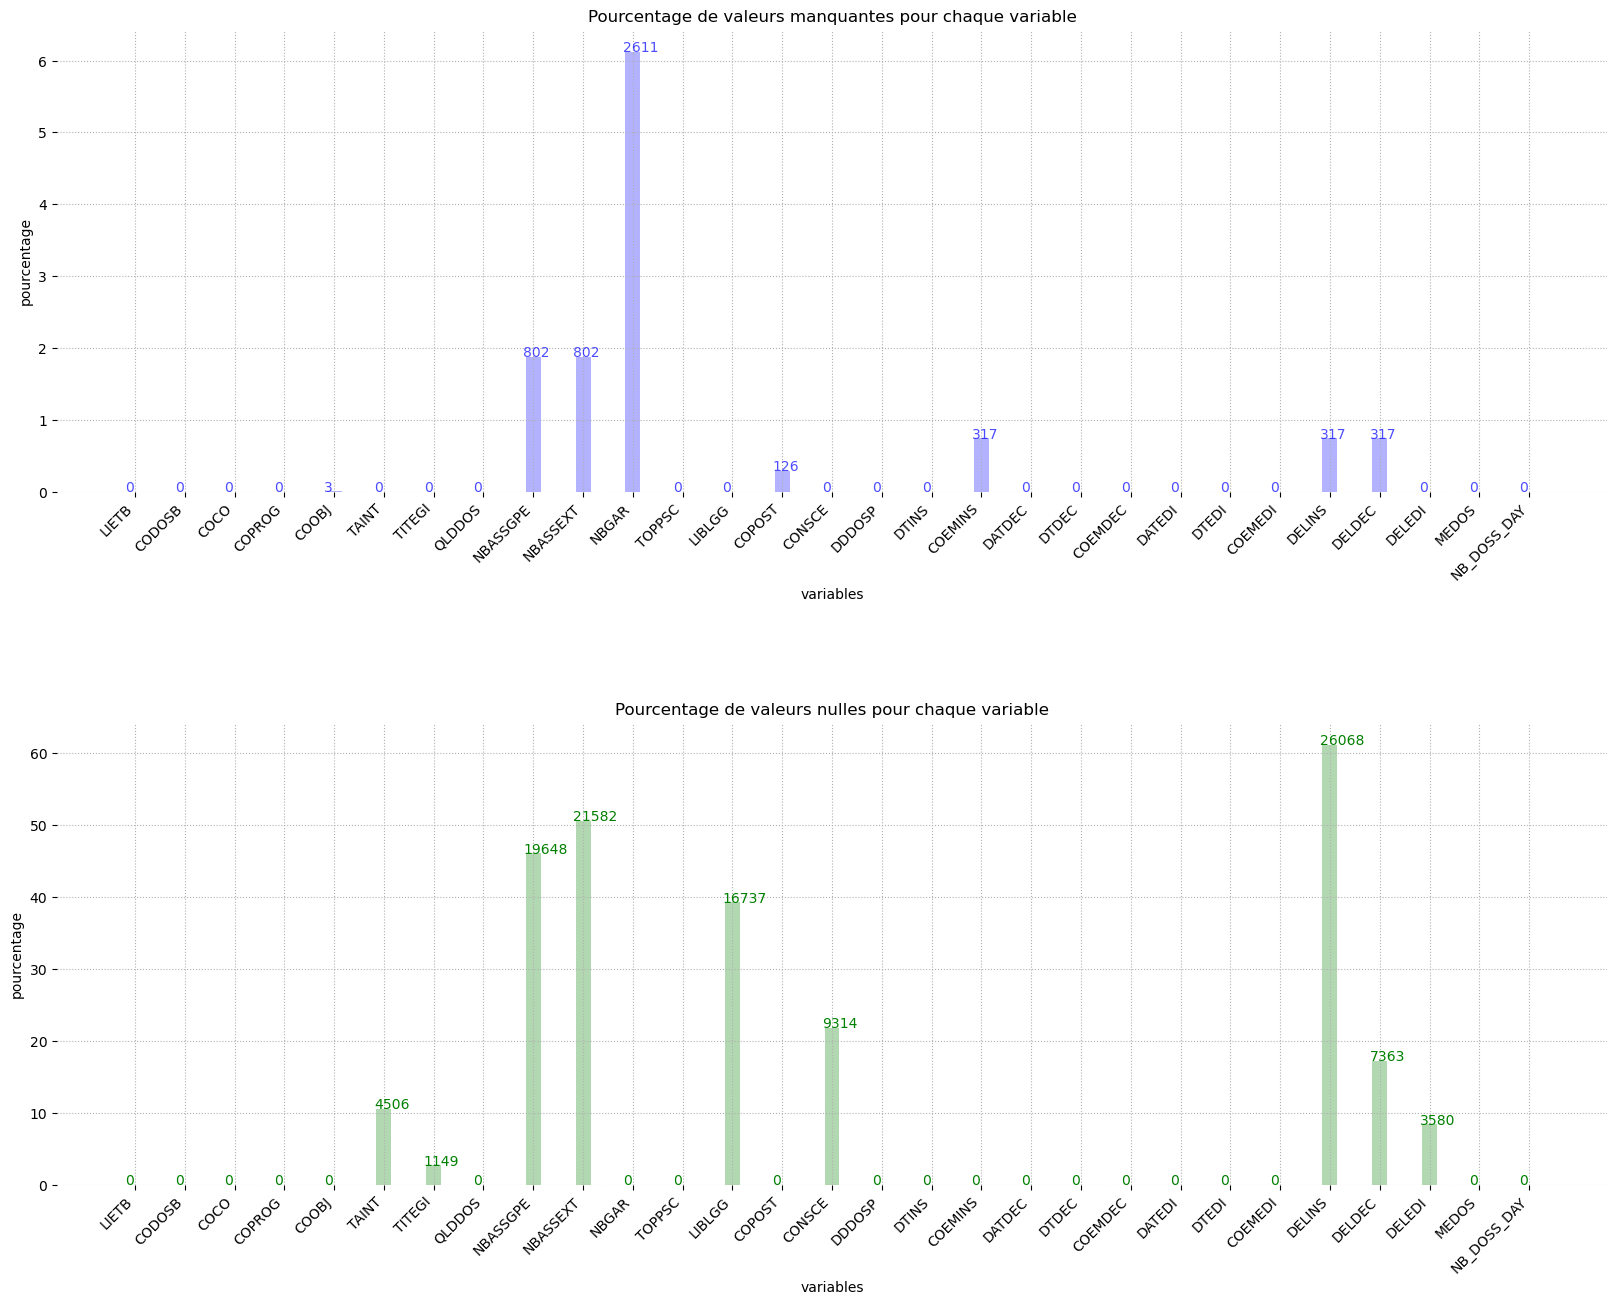

In [4]:
dv.plot_na_null(credits,credits.columns,fig_size=[20,15],plot_null=True)

**Observations:**

Parmi les variables que l'on va sélectionner, on observe des variables manquantes pour:
- `NBGAR` (Nbre de garanties) $\rightarrow$ on observe des valeurs manquantes pour `NBGAR` et aucune valeur nulle. On en déduit que lorsqu'un client n'a pas de garanties, la variable est manquante. On met donc toutes les variables manquantes de `NBGAR` à 0.
- `DELINS` (Nbre jours Instruction) $\rightarrow$ on sait que `DELINS` = `DTINS`(Date instruction traitée) - `DDD0SP`(Date instruction à traiter). Or nous avons déjà interpolé la variable `DTINS` et la variable `DDD0SP` n'est pas manquante. Nous pouvons donc calculer les valeurs manquantes de `DELINS`. 
- `DELDEC` (Nbre jrs Décision) $\rightarrow$ on sait que `DELDEC` = `DTDEC`(Date accord banque traitée) - `DATDEC`(Date accord banque à traiter). Or nous avons déjà interpolé la variable `DATDEC` et la variable `DTDEC` n'est pas manquante. Nous pouvons donc calculer les valeurs manquantes de `DELDEC`
- `NBASSGPE`(Nbre Assurance Groupe) et `NBASSEXT`(Nbre Assurance Externe)  $\rightarrow$  on observe le même nombre de valeurs manquantes pour ces 2 variables et après calcul on voit que les valeurs sont manquantes aux mêmes endroits pour ces deux variables. Or, un client est supposé posseder soit une assurance de groupe, soit une assurance externe. De plus, on voit que `NBASSGPE` et `NBASSEXT` ont environ le même nombre de 0. Pour un dossier dont l'assurance est manquante, on va donc tirer aléatoirement (avec proba 1/2) une assurance entre `NBASSGPE` et `NBASSEXT`, par exemple `NBASSGPE`. On met la valeur de `NBASSGPE` à 0 et on prend pour `NBASSEXT`, la moyenne. 
-  `COOBJ` (Code objet prêt) $\rightarrow$ possède très peu de valeurs manquantes. On impute par la modalité majoritaire.

In [5]:
# Imputation des données manquantes 
# -------------------------------------
credits = dp1.fill_na_1(credits)

## Sélection de variables 

In [6]:
# Selection des variables définies par l'analyse Exploratoire
# A EFFECTUER APRES fill_na_1
# -------------------------------------
credits1 = credits[VAR_DATE_CREDIT_1+VAR_QUANTI_CREDIT_1+VAR_QUALI_CREDIT_1+VAR_REP_1]

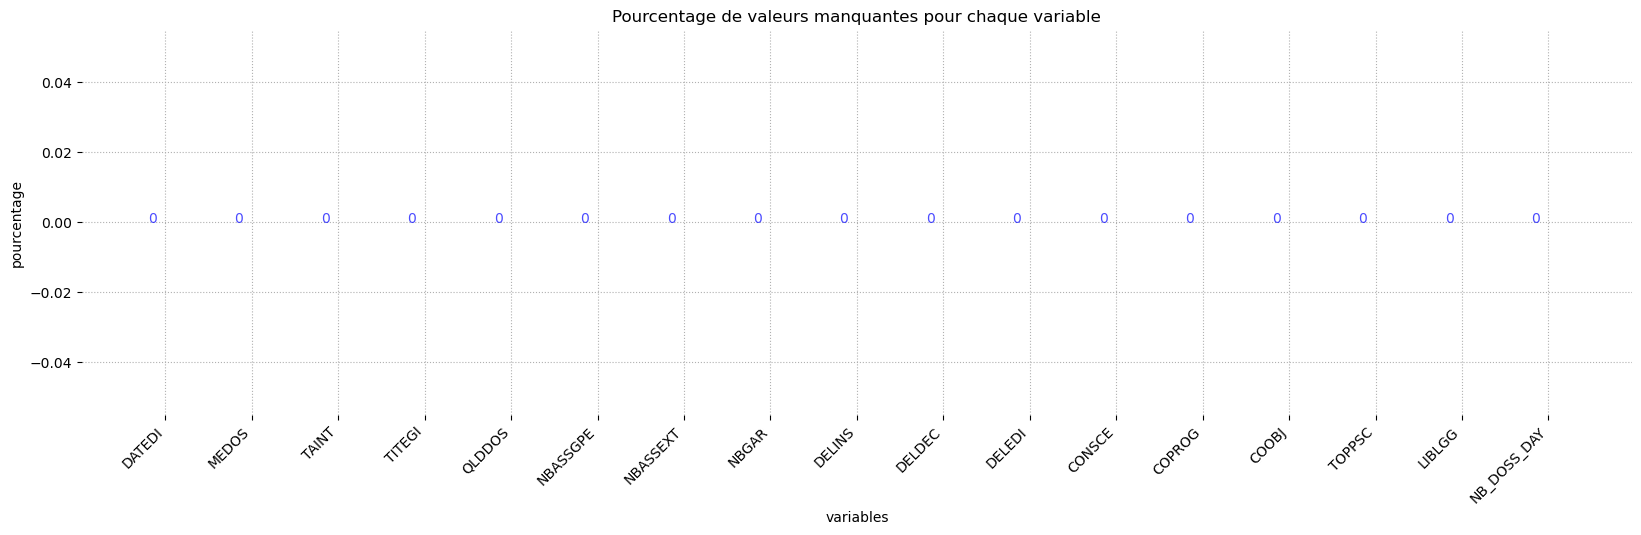

In [7]:
# Vérification qu'il ne reste plus de variables manquantes
# -------------------------------------
dv.plot_na_null(credits1,credits1.columns,fig_size=[20,5],plot_null=False)

## Cas Univarié

### Création TS

TS : Time Series = série temporelle univariée.

Afin d'avoir le format d'une Série Temporelle, on compte le nombre de crédits par jour (ou par semaine) et on met la valeur 0 si il n'y a pas de crédits. La série temporelle obtenue est continue dans le temps (les dates se suivent tous les jours ou toutes les semaines).

In [8]:
# Définition de séries temporelles univariées 
# ----------------------------------------------
# Données regroupées par jour
TS_day   = dp1.create_TS(credits,by='day')
# Données regroupées par buisiness day (jour sans le dimanche)
TS_day_B = dp1.create_TS(credits,by='business_day')
# Données regroupées par semaine
TS_week  = dp1.create_TS(credits,by='week')

### Débruitage

In [9]:
# Exploration des paramètres de  débruitage pour trouver les meilleurs paramètres 
# ----------------------------------------------
_ = interact(dn.plot_dash_debruitTrans, **arg_dash, 
             TS_week=fixed(TS_week), TS_day=fixed(TS_day))

interactive(children=(ToggleButtons(button_style='success', description='signal', options=('TS_week', 'TS_day'…

**Observations:**

Après réglage des paramètres, on retient les valeurs :

- pour TS_day: wave='sym19', seuil=0.5, translation=8 (on ne peut pas trop débruiter au risque de perdre beaucoup d'information.)

- pour TS_week: wave='sym11',seuil=1.5, translation=8

In [10]:
# Une fois que l'on a trouvé les bons paramètres avec le panel ci-dessus, on définit le signal débruité
# ----------------------------------------------
TSrec_day,_  = dn.DebruitTrans(TS_day,qmf='db3',T=.5,trans=8)
TSrec_week,_ = dn.DebruitTrans(TS_week,qmf='sym11',T=1.5,trans=8) #'db9'

### Données regroupées par jour

### Données regroupées par semaine

In [57]:
import tick
import datetime as dt
from tick.hawkes import HawkesExpKern,HawkesSumExpKern,HawkesEM

In [12]:
"""
Reference:
----------
https://stats.stackexchange.com/questions/366381/fit-hawkes-process-to-1d-data-using-python-package-tick

data exemple: 
https://github.com/X-DataInitiative/tick-datasets/tree/master/hawkes/bund
https://x-datainitiative.github.io/tick/modules/generated/tick.dataset.fetch_hawkes_bund_data.html#tick.dataset.fetch_hawkes_bund_data
https://x-datainitiative.github.io/tick/auto_examples/plot_hawkes_finance_data.html#example-plot-hawkes-finance-data-py
https://x-datainitiative.github.io/tick/_modules/tick/dataset/fetch_hawkes_data.html

"""

'\nReference:\n----------\nhttps://stats.stackexchange.com/questions/366381/fit-hawkes-process-to-1d-data-using-python-package-tick\n\ndata exemple: \nhttps://github.com/X-DataInitiative/tick-datasets/tree/master/hawkes/bund\nhttps://x-datainitiative.github.io/tick/modules/generated/tick.dataset.fetch_hawkes_bund_data.html#tick.dataset.fetch_hawkes_bund_data\nhttps://x-datainitiative.github.io/tick/auto_examples/plot_hawkes_finance_data.html#example-plot-hawkes-finance-data-py\nhttps://x-datainitiative.github.io/tick/_modules/tick/dataset/fetch_hawkes_data.html\n\n'

Le processus de Hawkes est un processus de comptage qui compte une valeur par unité de temps. Cependant dans notre problème, nous comptons le nombre de dossiers qui arrivent au backOffice par jour et nous pouvons donc avoir plusieurs dossiers qui arrivent le même jour, ce qui ne peut pas être modélisé tel quel par un processus de Hawkes. 

Afin de recréer artificiellement la condition : un dossier qui arrive par unité de temps, nous allons travailler au niveau des minutes ou des secondes.

In [13]:
def divide_range_date(start,end,N):
    """
    Cette fonction divise la plage entre deux 
    dates en N durées égales.
    
    Ex: start = Timestamp('2017-10-19 00:00:00'), 
        end   = Timestamp('2017-10-20 00:00:00'), N=4 
        alors res = [Timestamp('2017-10-19 00:00:00'),
                    Timestamp('2017-10-19 06:00:00'),
                    Timestamp('2017-10-19 12:00:00'),
                    Timestamp('2017-10-19 18:00:00')]
    
    Input:
    -----
    - start (pd.Timestamp): date de début
    - end (pd.Timestamp): date de fin
    - N (int): nombre de sub-divisions
    
    Output:
    ------
    - res (liste de pd.Timestamp): N dates entre 
      start et end.  
    """
    res = []
    # getting diff.
    diff = (end - start) // N
    for idx in range(0, N):
        # computing new dates
        res.append((start + idx * diff))

    return res

In [14]:
def create_TS_hawkes(TS_day):
    """
    Cette fonction prend en entrée une série temporelle avec pour chaque date en index,
    le nombre de dossiers qui arrivent au backOffice en valeur. 
    La fonction interpole les dates de façon à avoir un dossier par unité de temps. 
    On ne gardera ensuite que les temps d'arrivée des dossiers. 

    En effet, le processus de Hawkes est un processus de comptage qui compte une
    valeur par unité de temps. Cependant dans notre problème, nous comptons le nombre 
    de dossiers qui arrivent au backOffice par jour et nous pouvons donc avoir plusieurs 
    dossiers qui arrivent le même jour, ce qui ne peut pas être modélisé tel quel par un 
    processus de Hawkes.

    Afin de recréer artificiellement la condition "un dossier qui arrive par 
    unité de temps", nous allons interpoler les dates en ajoutant n lignes pour 
    chaque date où n = nombre de dossiers maximal par jour que l'on puisse avoir. 

    Ex: si il y a au maximum 3 dossiers par jours (n=3) alors 
    TS = [2017-10-19  0,  
          2017-10-20  2,
          2017-10-21  3]

    devient : TS_aug = [2017-10-19 00:00:00  0,
                        2017-10-19 08:00:00  0,
                        2017-10-19 16:00:00  0,
                        2017-10-20 00:00:00  1,
                        2017-10-20 08:00:00  2,
                        2017-10-20 16:00:00  0,
                        2017-10-21 00:00:00  1,
                        2017-10-21 08:00:00  2,
                        2017-10-21 16:00:00  3]

    et on ne veux que les timestemps pour lesquels un dossier est arrivé donc 
    on renvoie: TS_final = [array([2017-10-20 00:00:00, 2017-10-20 08:00:00, 
                           2017-10-21 00:00:00, 2017-10-21 08:00:00 ,
                           2017-10-21 16:00:00])].

    /.\ Met une trentaine de secondes ou + à run.

    Input:
    ------
    - TS_day (pd.series): série temporelle avec en index une date 
      et en valeur, le nombre de 'CODOSB' par jour.
      (Ne traite pas le cas des données regroupées par semaine car 
      en interpolant les dates de façon à avoir 1 dossier/unité de temps,
      cela reviendrait à prendre par jours).

    Ouput:
    ------
    - TS_final(liste contenant 1 array): série temporelle finale représentant les 
      temps d'arrivée des dossiers au backOffice. Voir l'exemple pour 
      avoir la structure  de TS_final. 
    """

    TS = TS_day.copy()

    # Trouver la valeur maximale de la ST
    TS_max=np.max(TS)
    #TS_max = 4
    #--- Pour avoir 1 dossier par unité de temps, on divise une journée en TS_max parties :

    # Création d'une DataFrame avec 2 colonnes: DATEDI et CODOSB
    # i.e: DATEDI était en indice et il passe à présent en colonne
    # tandis que les indices sont remis de 0 à len(TS)
    TS = pd.DataFrame(TS)
    TS.reset_index(inplace=True)

    # création d'une nouvelle colonne pour
    # sauvegarder les indices de départ avant de 
    # dupliquer la dataframe dans la suite du code
    TS['save_idx'] = TS.index

    # on duplique les lignes de TS "TS_max" fois chacune
    aug_TS=pd.DataFrame(np.repeat(TS.values,TS_max,axis=0))
    aug_TS.columns = TS.columns

    # on met la valeur NaN aux lignes dupliquées sauf à la colonne save_idx
    idx_dupli = np.where(aug_TS.duplicated())[0] # indices des lignes dupliquées
    aug_TS['DATEDI'].iloc[idx_dupli] = np.nan
    aug_TS['CODOSB'].iloc[idx_dupli] = np.nan

    # indices où la date n'est pas NaN 
    idx_date = np.where(aug_TS['DATEDI'].notna())
    # dates de début (/.\ de taille len(TS)-1)
    starts = aug_TS['DATEDI'].iloc[idx_date][:-1]
    # dates de fin (/.\ de taille len(TS)-1)
    ends  = aug_TS['DATEDI'].iloc[idx_date][1:]


    for i in range(len(TS)):
        # indices de aug_TS correspondant à save_idx=i
        idx_i = np.where(aug_TS.save_idx==i)[0]

        # =====================================
        # Si pour la ligne correspondant à save_idx=i,
        # on a n=4 CODOSB, alors la colonne correspondant à CODOSB
        # sera de taille TS_max et prendra la valeur [1,2,3,4,0,0...0].
        # On complète de l'indice 4 à la TS_max avec des 0
        # =====================================
        # premier indice de idx_i = nb de CODOSB 
        n = aug_TS['CODOSB'].iloc[idx_i[0]]

        # vecteur de taille TS_max la forme [1,2,...,n,0,0,0,0]
        complete = np.zeros(TS_max)
        complete[:n] = np.arange(n)+1

        aug_TS['CODOSB'].iloc[idx_i] = complete.astype(int)

        # =====================================
        # interpolation de la date avec la fonction divide_range_date 
        # (la fonction interpolate de python donnait partout la même valeur)
        # on remplit les valeurs NaN entre 2 dates non NaN.
        #aug_TS['DATEDI'].iloc[idx_i]  = divide_range_date(starts.iloc[i],ends.iloc[i],TS_max)
        # =====================================
        # on ne vas pas jusqu'à la fin des indices car
        # starts et ends ont 1 élément de moins que aug_TS
        if i!=len(TS)-1:
            aug_TS['DATEDI'].iloc[idx_i] = divide_range_date(starts.iloc[i],ends.iloc[i],TS_max)

        # pour le dernier élément (i=len(TS)), on calcule 
        # la date de fin comme étant ends[i-1]+(1 jour) 
        else:
            # calcul de la date de fin
            start = aug_TS['DATEDI'].iloc[idx_i].iloc[0]
            end = start + dt.timedelta(days=1)
            # mise à jour des dernières lignes de aug_TS
            aug_TS['DATEDI'].iloc[idx_i] = divide_range_date(start,end,TS_max)

    # on met la Série temporelle au bon format final:
    # on enlève la colonne permettant de sauvegarder l'indice
    aug_TS.drop(['save_idx'],axis=1,inplace=True)
    # on ne garde que les dates qui sont associées à un CODOSB non nul
    TS_final = [aug_TS['DATEDI'].iloc[np.where(aug_TS['CODOSB']!=0)[0]].values]
    
    return TS_final

In [15]:
TS_haw = create_TS_hawkes(TS_day)

In [22]:
def format_timestamp(event_timestamps):
    """
    Cette fonction prend en entrée la liste de timestamps 
    renvoyée par create_TS_hawkes() et renvoie la même liste 
    modifée telle que les timestamps commencent à 0 et 
    on divise chaque timestamp par le nombre de ns dans une journée.
    
    Input:
    -----
    - event_timestamps (liste contenant 1 array): série temporelle représentant les 
      temps d'arrivée des dossiers au backOffice. Sortie de la fonction 
      create_TS_hawkes() (voir l'exemple de create_TS_hawkes). 
    
    Ouput:
    -----
    - event_timestamps (liste contenant 1 array): série temporelle représentant les 
      temps d'arrivée modifiée.
    - start_time (datetime): temps de début de la série temporelle.
    """
    # temps de début de la série temporelle
    start_time = min([min(timestamp) for timestamp in event_timestamps])
    # temps de fin de la série temporelle
    end_time = max([max(timestamp) for timestamp in event_timestamps])
    # on fait en sorte que le 1er temps d'arrivée soit 0 et on divise par
    # 86400e9 = nombre de ns par jour
    event_timestamps = [(timestamps-start_time).astype(np.float64)/86400e9 for timestamps in event_timestamps]

    return event_timestamps,start_time

In [23]:
event_timestamps,start_time = format_timestamp(TS_haw)

In [18]:
event_timestamps

[array([   0.        ,   36.        ,   55.        , ..., 1897.02678571,
        1898.        , 1898.00892857])]

In [ ]:
decay_candidates

In [19]:
# Avec le kernel Exponentiel
# =======================================
"""
Le module tick ne nous permet d'estimer notre processus de Hawkes que pour une valeur 
fixe de la β pour un noyau exponentiel ϕ(t)=αβexp(-βt). En effet, estimer conjointement
α et β conduit à des algorithmes non convexes et peu évolutifs.

Cependant, nous pouvons essayer plusieurs valeurs de β et garder celle qui nous donne 
le meilleur score.

"""
best_score = -1e100
decay_candidates = np.logspace(0, 10, 30)

print("Recherche du meilleur paramètres decay :")
for i, decay in enumerate(decay_candidates):
    hawkes_learner = HawkesExpKern(decay, verbose=False, max_iter=10000,
                                   tol=1e-10)
    
    hawkes_learner.fit(event_timestamps)

    hawkes_score = hawkes_learner.score()
    if hawkes_score > best_score:
        print('obtient score={}\navec decay={}\n'.format(hawkes_score, decay))
        best_hawkes = hawkes_learner
        best_score = hawkes_score

Recherche du meilleur paramètres decay :
obtient score=38.56594738090839
avec decay=1.0

obtient score=46.27867158108251
avec decay=2.2122162910704493

obtient score=58.24283568445357
avec decay=4.893900918477494

obtient score=71.8398923238069
avec decay=10.826367338740546

obtient score=74.81567755951698
avec decay=23.95026619987486



In [130]:
# Avec une somme kernel exponentiels
# (il y a trop de paramètres, je ne sais pas quoi mettre)
# =======================================
best_score = -1e100

decays_candidates = [[20,1,8],np.logspace(1, 10, 3)]
n_baselines = 3
period_length = 1

print("Recherche des meilleurs paramètres :")
for i, decays in enumerate(decays_candidates):
    hawkes_learner = HawkesSumExpKern (decays=decays, n_baselines=n_baselines, 
                                   period_length=period_length, verbose=False,
                                   max_iter=10000, tol=1e-10)

    hawkes_learner.fit(event_timestamps)
    hawkes_score = hawkes_learner.score()

    if hawkes_score > best_score:
        print('obtient score={}\navec decays={}\n'.format(hawkes_score, decays))
        best_hawkes = hawkes_learner
        best_score = hawkes_score

Recherche des meilleurs paramètres :
obtient score=77.65585182456196
avec decays=[20, 1, 8]



In [131]:
learner=best_hawkes

In [133]:
"""
intensité = lambda(t)
"""
learner.fit(event_timestamps)

# intensity_tracked_times= temp t et tracked_intensity=valeurs de lambda(t) 
# intensity_track_step = How often the intensity should be computed
tracked_intensity, intensity_tracked_times = learner.estimated_intensity(event_timestamps,intensity_track_step=1/24)

estimated_intensity_index = start_time + pd.to_timedelta(intensity_tracked_times,unit='D')

estimated_intensity = pd.DataFrame(np.vstack(tracked_intensity).T,index=estimated_intensity_index)
estimated_intensity.rename(columns={0:'NB_DOSS'},inplace=True)

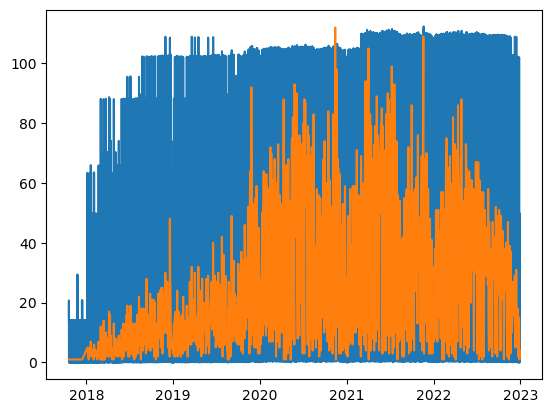

In [136]:
import matplotlib.pyplot as plt
plt.plot(estimated_intensity)
plt.plot(TS_day[np.where(TS_day>=1)[0]])

In [138]:
from tick.hawkes import HawkesKernelTimeFunc

t_values = np.array([0, 1, 1.5], dtype=float)
y_values = np.array([0, .2, 0], dtype=float)

tf1 = TimeFunction([t_values, y_values],
                   inter_mode=TimeFunction.InterConstRight, dt=0.1)
kernel_1 = HawkesKernelTimeFunc(tf1)

In [ ]:
import numpy as np
from tick.hawkes import HawkesExpKern
from tick.plot import plot_hawkes_kernel_norms
from tick.hawkes import HawkesConditionalLaw

# récupération du dataset
os.chdir(PATH)
timestamps_file = np.load('bund.npz',allow_pickle=True)
print(timestamps_file.files)

In [ ]:
# mise au bon format de timestamps_list
timestamps_list = []
for f in timestamps_file:
    timestamps_list.append(list(timestamps_file[f])) 

il faut que le temps commence à 0.

La liste timestamps_list['20140417'] contient juste les timestamps des moments d'arrivée. car on compte 1 élément par arrivée

In [ ]:
best_score = -1e100
decay_candidates = np.logspace(0, 6, 20)
for i, decay in enumerate(decay_candidates):
    hawkes_learner = HawkesExpKern(decay, verbose=False, max_iter=10000,
                                   tol=1e-10)
    hawkes_learner.fit(timestamps_list)

    hawkes_score = hawkes_learner.score()
    if hawkes_score > best_score:
        print('obtained {}\n with {}\n'.format(hawkes_score, decay))
        best_hawkes = hawkes_learner
        best_score = hawkes_score

plot_hawkes_kernel_norms(best_hawkes, show=True)

In [ ]:
best_hawkes.get_kernel_values

In [ ]:
dir(best_hawkes)

In [ ]:
[[best_hawkes,best_hawkes]]

In [ ]:
hawkes = SimuHawkes(kernels=best_hawkes, baseline=1.5, verbose=False, seed=23983)

run_time = 40
dt = 0.01
hawkes.track_intensity(dt)
hawkes.end_time = run_time
hawkes.simulate()

fig, ax = plt.subplots(hawkes.n_nodes, 1, figsize=(14, 8))
plot_point_process(hawkes, t_max=20, ax=ax)

plt.show()

In [ ]:
 kernel_2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from tick.base import TimeFunction
from tick.hawkes import SimuHawkes, HawkesKernelExp, HawkesKernelTimeFunc
from tick.plot import plot_point_process

t_values = np.array([0, 1, 1.5], dtype=float)
y_values = np.array([0, .2, 0], dtype=float)
tf1 = TimeFunction([t_values, y_values],
                   inter_mode=TimeFunction.InterConstRight, dt=0.1)
kernel_1 = HawkesKernelTimeFunc(tf1)

t_values = np.array([0, .1, 2], dtype=float)
y_values = np.array([0, .4, -0.2], dtype=float)
tf2 = TimeFunction([t_values, y_values], inter_mode=TimeFunction.InterLinear,
                   dt=0.1)
kernel_2 = HawkesKernelTimeFunc(tf2)

hawkes = SimuHawkes(
    kernels=[[kernel_1, kernel_1], [HawkesKernelExp(.07, 4), kernel_2]],
    baseline=[1.5, 1.5], verbose=False, seed=23983)

run_time = 40
dt = 0.01
hawkes.track_intensity(dt)
hawkes.end_time = run_time
hawkes.simulate()

fig, ax = plt.subplots(hawkes.n_nodes, 1, figsize=(14, 8))
plot_point_process(hawkes, t_max=20, ax=ax)

plt.show()

In [ ]:
def create_TS_hawkes(TS_day):
    """
    Cette fonction prend en entrée une série temporelle (avec des dates en index)
    et ajoute des lignes en interpolant les dates de façon à avoir un dossier par ligne.
    Utilise la fonction divide_range_date()

    En effet, le processus de Hawkes est un processus de comptage qui compte une
    valeur par unité de temps. Cependant dans notre problème, nous comptons le nombre 
    de dossiers qui arrivent au backOffice par jour et nous pouvons donc avoir plusieurs 
    dossiers qui arrivent le même jour, ce qui ne peut pas être modélisé tel quel par un 
    processus de Hawkes.

    Afin de recréer artificiellement la condition "un dossier qui arrive par 
    unité de temps", nous allons interpoler les dates en ajoutant n lignes pour 
    chaque date où n = nombre de dossiers maximal par jour que l'on puisse avoir. 

    Ex: si il y a au maximum 3 dossiers par jours (n=3) alors 
    TS = [2017-10-19  0,  
          2017-10-20  2,
          2017-10-21  3]

    devient : TS_aug = [2017-10-19 00:00:00  0,
                        2017-10-19 08:00:00  0,
                        2017-10-19 16:00:00  0,
                        2017-10-20 00:00:00  1,
                        2017-10-20 08:00:00  2,
                        2017-10-20 16:00:00  0,
                        2017-10-21 00:00:00  1,
                        2017-10-21 08:00:00  2,
                        2017-10-21 16:00:00  3]

    /.\ Met une trentaine de secondes ou + à run.

    Input:
    ------
    - TS_day (pd.series): série temporelle avec en index une date 
      et en valeur, le nombre de 'CODOSB' par jour.
      (Ne traite pas le cas des données regroupées par semaine car 
      en interpolant les dates de façon à avoir 1 dossier/unité de temps,
      cela reviendrait à prendre par jours).

    Ouput:
    ------
    - aug_TS(pd.series): série temporelle augmentée de façon à avoir un
      'CODOSB' par unité de temps avec en index une date 
       et en valeur, le nombre de 'CODOSB' par jour.
    """

    TS = TS_day.copy()

    # Trouver la valeur maximale de la ST
    TS_max=np.max(TS)
    #TS_max = 4
    #--- Pour avoir 1 dossier par unité de temps, on divise une journée en TS_max parties :

    # Création d'une DataFrame avec 2 colonnes: DATEDI et CODOSB
    # i.e: DATEDI était en indice et il passe à présent en colonne
    # tandis que les indices sont remis de 0 à len(TS)
    TS = pd.DataFrame(TS)
    TS.reset_index(inplace=True)

    # création d'une nouvelle colonne pour
    # sauvegarder les indices de départ avant de 
    # dupliquer la dataframe dans la suite du code
    TS['save_idx'] = TS.index

    # on duplique les lignes de TS "TS_max" fois chacune
    aug_TS=pd.DataFrame(np.repeat(TS.values,TS_max,axis=0))
    aug_TS.columns = TS.columns

    # on met la valeur NaN aux lignes dupliquées sauf à la colonne save_idx
    idx_dupli = np.where(aug_TS.duplicated())[0] # indices des lignes dupliquées
    aug_TS['DATEDI'].iloc[idx_dupli] = np.nan
    aug_TS['CODOSB'].iloc[idx_dupli] = np.nan

    # indices où la date n'est pas NaN 
    idx_date = np.where(aug_TS['DATEDI'].notna())
    # dates de début (/.\ de taille len(TS)-1)
    starts = aug_TS['DATEDI'].iloc[idx_date][:-1]
    # dates de fin (/.\ de taille len(TS)-1)
    ends  = aug_TS['DATEDI'].iloc[idx_date][1:]


    for i in range(len(TS)):
        # indices de aug_TS correspondant à save_idx=i
        idx_i = np.where(aug_TS.save_idx==i)[0]

        # =====================================
        # Si pour la ligne correspondant à save_idx=i,
        # on a n=4 CODOSB, alors la colonne correspondant à CODOSB
        # sera de taille TS_max et prendra la valeur [1,2,3,4,0,0...0].
        # On complète de l'indice 4 à la TS_max avec des 0
        # =====================================
        # premier indice de idx_i = nb de CODOSB 
        n = aug_TS['CODOSB'].iloc[idx_i[0]]

        # vecteur de taille TS_max la forme [1,2,...,n,0,0,0,0]
        complete = np.zeros(TS_max)
        complete[:n] = np.arange(n)+1

        aug_TS['CODOSB'].iloc[idx_i] = complete.astype(int)

        # =====================================
        # interpolation de la date avec la fonction divide_range_date 
        # (la fonction interpolate de python donnait partout la même valeur)
        # on remplit les valeurs NaN entre 2 dates non NaN.
        #aug_TS['DATEDI'].iloc[idx_i]  = divide_range_date(starts.iloc[i],ends.iloc[i],TS_max)
        # =====================================
        # on ne vas pas jusqu'à la fin des indices car
        # starts et ends ont 1 élément de moins que aug_TS
        if i!=len(TS)-1:
            aug_TS['DATEDI'].iloc[idx_i] = divide_range_date(starts.iloc[i],ends.iloc[i],TS_max)

        # pour le dernier élément (i=len(TS)), on calcule 
        # la date de fin comme étant ends[i-1]+(1 jour) 
        else:
            # calcul de la date de fin
            start = aug_TS['DATEDI'].iloc[idx_i].iloc[0]
            end = start + dt.timedelta(days=1)
            # mise à jour des dernières lignes de aug_TS
            aug_TS['DATEDI'].iloc[idx_i] = divide_range_date(start,end,TS_max)


    # on remet la série temporelle selon le format d'oringine:
    # on met DATEDI en index et CODOSB en valeur
    aug_TS.index = aug_TS.DATEDI
    aug_TS.drop(['DATEDI','save_idx'],axis=1,inplace=True)
    # on passe du format pf.DataFrame au format pd.Series
    aug_TS = aug_TS.squeeze()
    
    return aug_TS